In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import os.path
import csv

fileNameArray = []

base_dir = os.path.join('velo') # alles zit in map 'velo'
#input_path_may_15 = os.path.join('', 'cyclingchallengemay15.csv') #mei 2015
input_path_apr_14 = os.path.join('', 'bike-usage-2014-04.csv') #bv velo/bike-usage-2014-04.csv
input_path_velo_stations = os.path.join('', 'velostation.csv') # alle fietsstations

#file_name_may_15 = os.path.join(base_dir, input_path_may_15)
file_name_apr_14 = os.path.join(base_dir, input_path_apr_14) # bv bike-usage-2014-04.csv
file_name_velo_stations = os.path.join(base_dir, input_path_velo_stations)
#filtered_may_15 = sc.textFile(file_name_may_15).filter(lambda l: 'id' not in l)
filtered_apr_14 = sc.textFile(file_name_apr_14).filter(lambda l: 'veloLocation' not in l)
filtered_velo_stations = sc.textFile(file_name_velo_stations).filter(lambda l: 'point_lat' not in l)


fileNameArray += file_name_apr_14

#print 'Count Apr 14: ' + str(filtered_apr_14.count())
print 'Count Velo Stations: ' + str(filtered_velo_stations.count())
#print filtered_velo_stations.take(1)
#print filtered_may_15.take(1)


Count Velo Stations: 146


In [3]:
import datetime
import numpy as np
import re
from pyspark.mllib.regression import LabeledPoint

def filter_coordinates(line):
    try:
        return LineString([line]).wkt
    except:
        return 0
    
def stations(line):
    try:
        if line.startswith('"') or line.endswith('"'):
            line = line.replace('\"','') # remove quotes from line (CSV)
            
        velo_data = line.split(';')
        features = []
        lbl = 0.0
        if float(velo_data[8]) >= 25.0:
            lbl = 1.0
        features.append(float(velo_data[0])) #id
        features.append(float(velo_data[1])) #objectid
        features.append(float(velo_data[2])) #point_lat
        features.append(float(velo_data[3])) #point_lng
        features.append(float(velo_data[6])) #o_id
        features.append(float(velo_data[8])) #aantal_loc
        
        return LabeledPoint(lbl, features)
    except:
        return LabeledPoint(0.0, [0.0 for i in range(10)])

def make_labeled_point(line):
    try:
        if line.startswith('"') or line.endswith('"'):
            line = line.replace('\"','') # remove quotes from line (CSV)
            
        velo_data = line.split(';')
        features = []
        lbl = 0.0
        features.append(float(velo_data[0]))         # Id
        #features.append(float(velo_data[1]))         # Trip-Id
        features.append(float(velo_data[2]))         # PointCourse
        #features.append((velo_data[3]))   # StartTime
        #features.append(days_from_nearest_holiday(int(flight_data[0]), int(flight_data[1]), int(flight_data[2]))) 
        #features.append(velo_data[4])       # StopTime
        features.append(float(velo_data[5])) # RealSpeed
        features.append(float(velo_data[6])) # Diff_Time
        #features.append(filter_coordinates(velo_data[7])) # Geometry
        #features.append(velo_data[7]) # Geometry

        return LabeledPoint(lbl, features)
    except:
        return LabeledPoint(0.0, [0.0 for i in range(10)])
    
    
def get_dates_day(date):
    try:
        for name in fileNameArray:
            if name in date:
                file = open(name, 'r')
                reader = csv.reader(file)
                for column in file:
                    if column:
                        return column[0]
                        print "column gevonden"
            else:
                return null
                print "niets gevonden"
    except:
        return null

In [4]:
#velo_data_may = filtered_may_15.map(lambda line: make_labeled_point(line))
#velo_data_may.cache()

velo_stations = filtered_velo_stations.map(lambda line: stations(line))
velo_stations.cache()

#print velo_data_may.take(1)
print velo_stations.take(1)

[LabeledPoint(1.0, [1.0,1.0,51.2280849969,4.40899727964,129.0,36.0])]


In [5]:
from pyspark.mllib.regression import LabeledPoint


    
#coordinates_velo = filtered_velo_stations.map(get_station_coordinates)


#print coordinates_velo.take(1)

lons = []
lats = []
loc = []
size = []


#for obj in enumerate(velo_stations.take(1)[0]):
lats += velo_stations.map(lambda lp: (float(lp.features[2]))).collect()
lons += velo_stations.map(lambda lp: (float(lp.features[3]))).collect()
loc += velo_stations.map(lambda lp: (float(lp.features[5]))).collect()
size.append(int(140))
#size += velo_stations.map(lambda lp: (int(lp.features[5])) * 2).collect()

print size
#print lons
#print lats

#for obj in enumerate(velo_stations.take(1)):
#    print obj
#    lats.append(obj.map(lambda lp: (lp.features[2])))
    #lats.append(float(obj[1]))
    #lons.append(float(obj[1]))

[140]


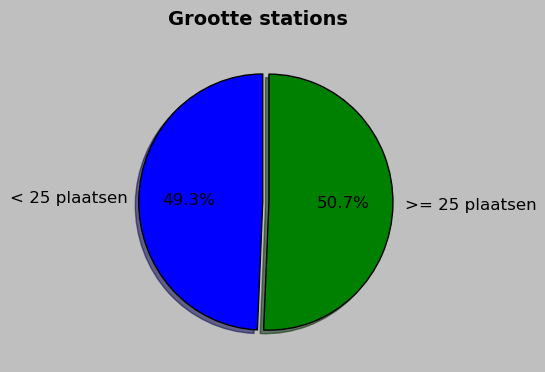

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

total = velo_stations.count()
size = velo_stations.filter(lambda lp: lp.label == 1.0).count() # filteren op labels met 1.0
labels = ['< 25 plaatsen', '>= 25 plaatsen']
fracs = [total - size, size]
explode = (0, 0.05)

fig = plt.figure(figsize=(4, 4)) #vierkante vormen, 2 naast 1 bv 7, 14
fig.suptitle('Grootte stations', fontsize=14, fontweight='bold')
ax = fig.add_subplot(111)
ax.pie(fracs, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
pass #vermijd tekst boven grafiek : om proper te formatteren

In [7]:
from IPython.display import HTML


input_form = """
    <div>
        <select id="months" onchange="filldays(this);" onfocus="this.selectedIndex = -1;">
            <option id="2014-01">Januari 2014</option>
            <option id="2014-04">April 2014</option>
            <option id="2014-07">Juli 2014</option>
            <option id="2014-10">Oktober 2014</option>
            <option id="2015-01">Januari 2015</option>
            <option id="2015-02">Februari 2015</option>
            <option id="2015-03">Maart 2015</option>
            <option id="2015-04">April 2015</option>
            <option id="2015-05">Mei 2015</option>
            <option id="2015-06">Juni 2015</option>
            <option id="2015-07">Juli 2015</option>
            <option id="2015-08">Augustus 2015</option>
            <option id="2015-09">September 2015</option>
        </select>
        
        <select id="days">
        
        </select>
       <!-- <input type="date" max="2011-12-31" min="2014-01-01" value="2015-10-31" id="dateControlledByRange"  />-->
        <input type="range" step="1" max="23" min="0" value="12" id="hour" /> 
        <input type="submit" onclick="submit();" />
    </div>

"""

javascript = """
<script>


/*webshim.polyfill('forms forms-ext');

jQuery(function($) {

    $('#dateControlledByRange').on('input', function() {
        $('#rangeControlledByDate').prop('valueAsNumber', $.prop(this, 'valueAsNumber'));
    });
    $('#rangeControlledByDate').on('input', function() {
        $('#dateControlledByRange').prop('valueAsNumber', $.prop(this, 'valueAsNumber'));
    });
});*/



</script>

<script type="text/Javascript">
    
    //select van dagen opvullen
    function filldays(d){
        var date = d[d.selectedIndex].id;
        date = date.split("-");
        var year = date[0] // jaar is nodig voor een schrikkeljaar te bepalen
        var month = date[1]
        
        var days = new Date(year, month, 0).getDate();
        
        $.each(str, function (idx, val) {
            $('#days').append("<option value='" + val + "'> " + val + " </option>");
        });
    }
    
    //datum van javascript naar python krijgen
    function submit(){
        var monthyear = $('#months option:selected').attr("id");
        monthyear = monthyear.split("-");
        var month = monthyear[1];
        var year = monthyear[0];
        var day = $("#days option:selected").text();
        window.alert("lol" + day + "lol");
        var hour = $("#hour").val();
        var var_name = "year";
        var var_value = year;
        var command = var_name + " = '" + var_value + "'";
        var kernel = IPython.notebook.kernel;
        kernel.execute(command);
        var_name = "month";
        var_value = month;
        var command = var_name + " = '" + var_value + "'";
        kernel.execute(command);
        var_name = "day";
        var_value = day;
        var command = var_name + " = '" + var_value + "'";
        kernel.execute(command);
        var_name = "hour";
        var_value = hour;
        var command = var_name + " = '" + var_value + "'";
        kernel.execute(command);
        //IPython.notebook.execute_all_cells();
        window.alert("done");
    }
</script>
"""

HTML(input_form + javascript)

http://server.arcgisonline.com/ArcGIS/rest/services/ESRI_StreetMap_World_2D/MapServer/export?bbox=1595635.43747,5672836.68694,1601343.86667,5678880.7549&bboxSR=5520&imageSR=5520&size=3000,3176&dpi=96&format=png32&f=image


NameError: name 'ClickInfo' is not defined

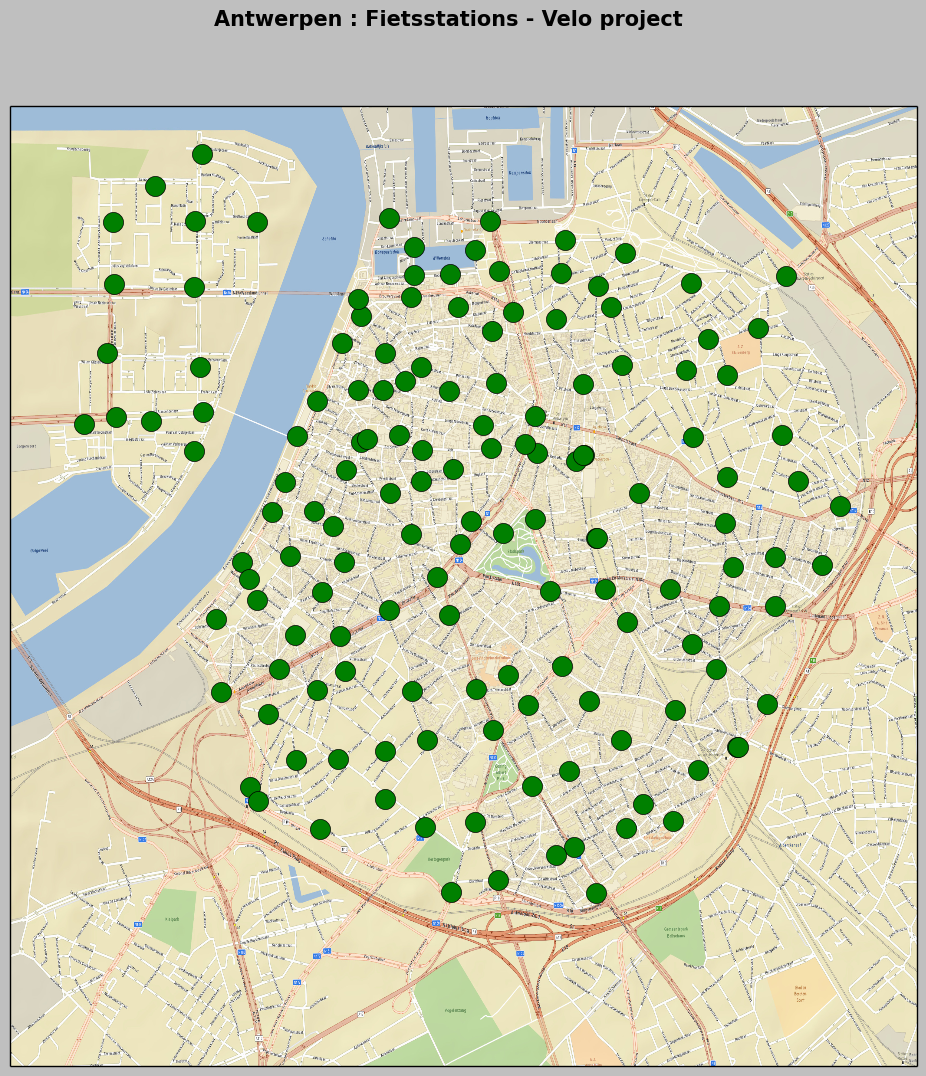

In [8]:
#TESTMAP

from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt, mpld3
import numpy as np
import mpld3
from mpld3 import plugins, utils

            

mpld3.enable_notebook()

center = [4.417978, 51.217098]
lon_range = 0.1
lat_range = 0.1
c1 = center[0] - (lon_range / 2) # 2 - left
c2 = center[1] - (lat_range / 3) # 3 - bottom
c3 = center[0] + (lon_range / 3) # 4 - right
c4 = center[1] + (lat_range / 5) # 3 - top
map = Basemap(llcrnrlon=c1,llcrnrlat=c2,urcrnrlon=c3,urcrnrlat=c4, epsg=5520)

#fig = plt.figure(figsize=(13, 13))
#fig, ax = plt.subplots(figsize=(12,12))

fig = plt.figure(figsize=(12,12))
fig.suptitle('Antwerpen : Fietsstations - Velo project', fontsize=15, fontweight='bold')
#fig.add_subplot(111)
# http://server.arcgisonline.com/arcgis/rest/services : ESRI_StreetMap_World_2D / ESRI_Imagery_World_2D
map.arcgisimage(service='ESRI_StreetMap_World_2D', xpixels=3000, verbose=True)

#fig, ax = plt.subplots(subplot_kw=dict(axisbg='#EEEEEE'))

x,y = map(lons, lats)
map.plot(x, y, 'bo', markersize=15, color='g')
#points = ax.plot(x, y, 'bo', markersize=30, color='g')


#for label, xpt, ypt in zip(loc, x, y): 
    #plt.text(xpt - 60, ypt - 15, label, color='white') # add capacity labels / , fontweight='bold'   
#    tooltip = mpld3.plugins.PointLabelTooltip(points, labels=label)
#    mpld3.plugins.connect(fig, tooltip)

#fig, ax = plt.subplots()
#fig, ax = plt.subplots()
points = ax.scatter(x, y,
                    s=500, alpha=0.3)

plugins.connect(fig, ClickInfo(points))
    
#plt.show()
#mpld3.display()



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import mpld3

mpld3.enable_notebook()

fig, ax = plt.subplots(subplot_kw=dict(axisbg='#EEEEEE'))
N = 100

scatter = ax.scatter(np.random.normal(size=N),
                     np.random.normal(size=N),
                     c=np.random.random(size=N),
                     s=1000 * np.random.random(size=N),
                     alpha=0.3,
                     cmap=plt.cm.jet)
ax.grid(color='white', linestyle='solid')

ax.set_title("Scatter Plot (with tooltips!)", size=20)

labels = ['point {0}'.format(i + 1) for i in range(N)]
tooltip = mpld3.plugins.PointLabelTooltip(scatter, labels=labels)
mpld3.plugins.connect(fig, tooltip)

mpld3.display()

In [ ]:
%matplotlib inline
from mpl_toolkits.basemap import Basemap 
import matplotlib.pyplot as plt
import numpy as np
import string
import matplotlib.cm as cm
import numpy as np
import matplotlib.pyplot as plt
import mpld3
from mpld3 import utils, plugins
mpld3.enable_notebook()

class ClickInfo(plugins.PluginBase):
    """Plugin for getting info on click"""
    
    JAVASCRIPT = """
    mpld3.register_plugin("clickinfo", ClickInfo);
    ClickInfo.prototype = Object.create(mpld3.Plugin.prototype);
    ClickInfo.prototype.constructor = ClickInfo;
    ClickInfo.prototype.requiredProps = ["id"];
    function ClickInfo(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };
    
    ClickInfo.prototype.draw = function(){
        var obj = mpld3.get_element(this.props.id);
        obj.elements().on("mousedown",
                          function(d, i){
                          alert("clicked on points[" + i + "]");
                          console.log(d);
                          });
    }
    """
    def __init__(self, points):
        self.dict_ = {"type": "clickinfo",
                      "id": utils.get_id(points)}
 
center = [4.417978, 51.217098]
lon_range = 0.1
lat_range = 0.1
c1 = center[0] - (lon_range / 2) # 2 - left
c2 = center[1] - (lat_range / 3) # 3 - bottom
c3 = center[0] + (lon_range / 3) # 4 - right
c4 = center[1] + (lat_range / 5) # 3 - top


fig = plt.figure(figsize=(13, 13))

m = Basemap(llcrnrlon=c1,llcrnrlat=c2,urcrnrlon=c3,urcrnrlat=c4, epsg=5520)



m.arcgisimage(service='ESRI_StreetMap_World_2D', xpixels=3000, verbose=True)

sizes = 30

x1,y1=m(x,y)

#fig, m = plt.subplots()

points = m.scatter(x, y, s=500, alpha=0.3)

plugins.connect(fig, ClickInfo(points))
plt.title("Flickr Geotagging Counts with Basemap")

pass #vermijd tekst boven grafiek : om proper te formatteren

#plt.show()
mpld3.display()